In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from markethistory import *

In [2]:
BATCH_SIZE = 128
NUM_FEATURE = 3
NUM_ASSET = 12
OBS_WINDOW = 50

EPISODE_WINDOW = 50

TXN_FEE = 0.0025
SAMPLING_BIAS = 1.3e-3 # This number needs to be carefully chosen.

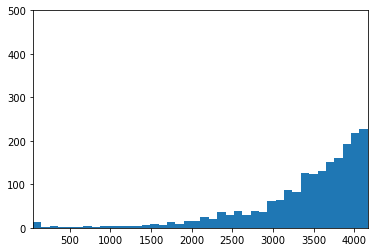

mean:  3403.0755
std:  734.204188765


In [3]:
# Find a good SAMPLING_BIAS

def sample(start, end, bias):
    """
    Geometrically sample a number in [START, END)
    
    Input:
    - start: the start (inclusive)
    - end: the end (exclusive)
    - bias: a number between 0 to 1. The closer the bias to 1, the more
      likely to generate a sample closer to END.
    """
    offset = np.random.geometric(bias)
    return max(end - offset, start)

start, end = 50, 4166 # end is the total time length of training data
data = [sample(start, end, 1.3e-3) for _ in range(2000)]
plt.hist(data, 40)
plt.axis([start, 4166, 0, 500])
plt.show()
print("mean: ", np.mean(data))
print("std: ", np.std(data))

#### Read price history from database

In [4]:
start = '2017/12/17'
end = '2018/04/20'
markethistory = MarketHistory(start, end)

#### Add constant cash (BTC) price info

In [52]:
data_global = markethistory.data
num_feature, num_asset, T = data_global.shape
btc_price_tensor = np.ones((num_feature, 1, T))
data_global = np.concatenate((btc_price_tensor, data_global), axis=1)
print("Global data tensor shape:", data_global.shape)

Global data tensor shape: (3, 12, 5951)


#### Split data into train, validataion, test

In [61]:
T_test = int(0.1 * T)
T_valid = int(0.2 * T)
T_train = T - T_test - T_valid

data_global = torch.tensor(data_global, dtype=torch.float)
data_train = data_global[:, :, :T_train]
data_valid = data_global[:, :, T_train:T_train+T_valid]
data_test = data_global[:, :, T_train+T_valid:]
print("Training data tensor shape:   ", data_train.shape)
print("Validation data tensor shape: ", data_valid.shape)
print("Testing data tensor shape:    ", data_test.shape)

Training data tensor shape:    torch.Size([3, 12, 4166])
Validation data tensor shape:  torch.Size([3, 12, 1190])
Testing data tensor shape:     torch.Size([3, 12, 595])


#### Define Policy

In [36]:
class DecisionNetwork_CNN(nn.Module):
    """
    An EIIE style decision network implemented with CNN without separate
    cash bias.
    """
    
    def __init__(self):
        super(DecisionNetwork_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=NUM_FEATURE, 
                               out_channels=NUM_FEATURE, 
                               kernel_size=[1,NUM_FEATURE]) # can also use [1,2]
        self.conv2 = nn.Conv2d(in_channels=NUM_FEATURE, 
                               out_channels=20, # can also use 10
                               kernel_size=[1, OBS_WINDOW-2])
        self.conv3 = nn.Conv2d(in_channels=21, 
                               out_channels=1, 
                               kernel_size=[1, 1])
        
    def forward(self, obs, prev_pf_w):
        """
        Compute the forward pass. 
        
        Input:
        - obs: A fresh observation of the market environment at the current time step.
          A tensor of shape [BATCH_SIZE, NUM_FEATURE, NUM_ASSET, OBS_WINDOW].
        - prev_pf_w: The portfolio weight vector in the previous time step. A tensor
          of shape [BATCH_SIZE, NUM_ASSET].
        
        Returns:
        - new_pf_w: The new portfolio weight vector for the current time step. A tensor
          of shape [BATCH_SIZE, NUM_ASSET]
        """
        scores = nn.ReLU()(self.conv1(obs))
        scores = nn.ReLU()(self.conv2(scores))
        scores = torch.cat([scores, prev_pf_w.view(BATCH_SIZE, 1, NUM_ASSET, 1)], dim=1)
        scores = self.conv3(scores).squeeze()
        
        new_pf_w = F.softmax(scores, dim=1)
        return new_pf_w

#### Define helper functions for training

In [38]:
def sample(start, end, bias):
    """
    Geometrically sample a number in [START, END)
    
    Input:
    - start: the start (inclusive)
    - end: the end (exclusive)
    - bias: a number between 0 to 1. The closer the bias to 1, the more
      likely to generate a sample closer to END.
    """
    offset = np.random.geometric(bias)
    return max(end - offset, start)

def sample_batch(batch_size, start, end, bias):
    """
    Sample a batch of numbers geometrically distributed in [START, END)
    """
    return torch.tensor([sample(start, end, bias) for _ in range(batch_size)])

def get_observation(end_t_batch, history):
    """
    Get a batch of price history of length OBS_WINDOW, ending at END_T_BATCH (inclusive).
    
    Input:
    - end_t_batch: The end time indices of this observation. Shape: [BATCH_SIZE].
    - history: The price history tensor of shape [NUM_FEATURE, NUM_ASSET, T]
    
    Returns:
    - obs: A torch tensor of shape [BATCH_SIZE, NUM_FEATURE, NUM_ASSET, OBS_WINDOW]
    """
    obs = []
    for offset in range(OBS_WINDOW-1, -1, -1):
        t_batch = end_t_batch - offset
        observation = history[:, :, t_batch].permute(2, 0, 1)
        obs.append(observation)
    return torch.stack(obs, dim=-1)

def calculate_shrinkage(w, w_prev):
    """
    Calculate the porfolio value shrinkage during a portfolio weight re-allocation due
    to transaction fees.
    This function calculates the shrinkage using an iterative approximation method. See
    equation (14) of the Deep Portfolio Management paper. 
    
    Input:
    - w: Target portfolio weight tensor of shape [BATCH_SIZE, NUM_ASSET]
    - w_prev: Previous portfolio weight tensor of shape [BATCH_SIZE, NUM_ASSET]
    
    Returns:
    - shrinkage: Portfolio value shrinkage multipler tensor of shape [BATCH_SIZE]
    """
    w0_0, w0_m = w_prev[:, 0], w_prev[:, 1:]
    w1_0, w1_m = w[:, 0], w[:, 1:]
    
    const1 = 1 - TXN_FEE * w0_0
    const2 = 2 * TXN_FEE - TXN_FEE ** 2
    const3 = 1 - TXN_FEE * w1_0
    
    u = TXN_FEE * torch.sum(torch.abs(w0_m - w1_m))
    w1_m_T = w1_m.transpose(0, 1)
    while True:
        u_next = (const1 - const2*torch.sum(F.relu(w0_m - (u*w1_m_T).transpose(0,1)), dim=1)) / const3
        max_diff = torch.max(torch.abs(u - u_next))
        if max_diff <= 1e-10:
            return u_next
        u = u_next

#### Define training

In [84]:
# TODO: instaed of fixed window size, try randomized window size
# TODO: modify data matrix so that it includes a row of 1 for Cash
# TODO: think of better way to initialize the initial pf weights

def train(policy, data, lr=1e-3, episodes=10000):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    T = data.shape[-1]
    
    for i in range(episodes):
        # geometrically sample start times: [batch]
        start_indices = sample_batch(BATCH_SIZE, OBS_WINDOW, T-EPISODE_WINDOW, SAMPLING_BIAS)
        # initialize portfolio weights: [batch, asset]
        pf_w = (torch.ones(NUM_ASSETS) / NUM_ASSETS).repeat(BATCH_SIZE, 1)
        # initialize portfolio values: [batch]
        pf_v = torch.ones(BATCH_SIZE)
        
        # simulate one episode of live trading with the policy
        loss = 0
        price_curr = data[0, :, start_indices].transpose(0, 1) # [batch, asset]
        for t in range(0, EPISODE_WINDOW):
            price_next = data[0, :, start_indices+t+1].transpose(0, 1) # [batch, asset]
            obs = get_observation(start_indices+t, data)
            
            pf_w_t_start = policy.forward(obs, pf_w)
            shrinkage = calculate_shrinkage(pf_w_t_start, pf_w)
            pf_v_t_start = pf_v * shrinkage
            
            w_tmp = (price_next / price_curr) * pf_w_t_start # [batch, asset]
            w_tmp_sum = torch.sum(w_tmp, dim=1) # [batch]
            pf_v_t_end = w_tmp_sum * pf_v_t_start
            pf_w_t_end = w_tmp / w_tmp_sum.view(BATCH_SIZE, 1)
            
            batch_reward = torch.log(pf_v_t_end / pf_v)
            loss -= torch.sum(batch_reward) / BATCH_SIZE
            
            # update variables
            pf_w = pf_w_t_end
            pf_v = pf_v_t_end
            price_curr = price_next
        loss /= EPISODE_WINDOW
        
        #if i %  == 0:
        print("episode", i, " loss:", float(loss))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# THE REAL DEAL

In [85]:
policy = DecisionNetwork_CNN()

In [86]:
train(policy, data_train, lr=0.00028, episodes=1000)

episode 0  loss: 6.690469308523461e-05
episode 1  loss: 7.6522228482645e-05
episode 2  loss: 3.243281753384508e-06
episode 3  loss: -4.191596599412151e-05
episode 4  loss: 4.756957423524e-05
episode 5  loss: 4.302796151023358e-05
episode 6  loss: -1.973078542505391e-05
episode 7  loss: 9.261535160476342e-05
episode 8  loss: 5.934082582825795e-05
episode 9  loss: 7.768180512357503e-05
episode 10  loss: 0.0001297740964218974
episode 11  loss: 6.129692337708548e-05
episode 12  loss: 6.531638064188883e-05
episode 13  loss: 8.538219117326662e-05
episode 14  loss: 4.8699577746447176e-05
episode 15  loss: 0.00010443062637932599
episode 16  loss: 7.623177953064442e-05
episode 17  loss: 9.700693772174418e-05
episode 18  loss: 2.127499828930013e-05
episode 19  loss: 2.2565222025150433e-05
episode 20  loss: 6.155213486636057e-05
episode 21  loss: 6.53225215501152e-05
episode 22  loss: 0.00011391384759917855
episode 23  loss: 0.0001416382729075849
episode 24  loss: 4.9164038500748575e-05
episode 2

episode 201  loss: 7.836574513930827e-05
episode 202  loss: 3.914897024515085e-05
episode 203  loss: 3.992578058387153e-05
episode 204  loss: 0.0001468007976654917
episode 205  loss: -7.329944764933316e-06
episode 206  loss: 6.782457057852298e-05
episode 207  loss: 7.45283341530012e-06
episode 208  loss: 7.633302448084578e-05
episode 209  loss: 1.5869110939092934e-05
episode 210  loss: 6.334218778647482e-05
episode 211  loss: 2.3389726266032085e-05
episode 212  loss: -3.31859992002137e-05
episode 213  loss: 6.344612484099343e-05
episode 214  loss: 4.2855557694565505e-05
episode 215  loss: 6.856565596535802e-05
episode 216  loss: 2.5477827875874937e-05
episode 217  loss: 7.359744631685317e-05
episode 218  loss: 9.284928091801703e-05
episode 219  loss: 6.043410030542873e-05
episode 220  loss: 9.413183761353139e-06
episode 221  loss: 3.804539664997719e-05
episode 222  loss: -5.76095089854789e-06
episode 223  loss: 4.096447446499951e-05
episode 224  loss: 2.8904200007673353e-05
episode 225

episode 400  loss: 5.317647446645424e-05
episode 401  loss: 5.992987280478701e-05
episode 402  loss: 5.285409861244261e-05
episode 403  loss: 4.928608541376889e-05
episode 404  loss: 4.2813051550183445e-05
episode 405  loss: 5.525749656953849e-05
episode 406  loss: 5.21124093211256e-05
episode 407  loss: 4.839567918679677e-05
episode 408  loss: 2.751818101387471e-05
episode 409  loss: 3.405866300454363e-05
episode 410  loss: 3.29538706864696e-05
episode 411  loss: 4.437793177203275e-05
episode 412  loss: 4.8404730478068814e-05
episode 413  loss: 4.2719486373243853e-05
episode 414  loss: 4.189428000245243e-05
episode 415  loss: 4.978070137440227e-05
episode 416  loss: 4.700002318713814e-05
episode 417  loss: 6.172951543703675e-05
episode 418  loss: 4.181489930488169e-05
episode 419  loss: 3.411990837776102e-05
episode 420  loss: 6.097877485444769e-05
episode 421  loss: 3.940136593882926e-05
episode 422  loss: 6.833284714957699e-05
episode 423  loss: 3.886605554725975e-05
episode 424  lo

episode 599  loss: 4.60338887933176e-05
episode 600  loss: 4.0836017433321103e-05
episode 601  loss: 4.599442399921827e-05
episode 602  loss: 5.243182022240944e-05
episode 603  loss: 4.716190596809611e-05
episode 604  loss: 5.114440500619821e-05
episode 605  loss: 4.9881418817676604e-05
episode 606  loss: 4.8695186706027016e-05
episode 607  loss: 4.87421675643418e-05
episode 608  loss: 4.6580466005252674e-05
episode 609  loss: 4.8955524107441306e-05
episode 610  loss: 4.696052201325074e-05
episode 611  loss: 4.3528292735572904e-05
episode 612  loss: 4.476202593650669e-05
episode 613  loss: 4.464577796170488e-05
episode 614  loss: 4.527339115156792e-05
episode 615  loss: 4.4089760194765404e-05
episode 616  loss: 4.639030521502718e-05
episode 617  loss: 4.9580965423956513e-05
episode 618  loss: 4.99252273584716e-05
episode 619  loss: 4.434854781720787e-05
episode 620  loss: 4.749164145323448e-05
episode 621  loss: 4.528869976638816e-05
episode 622  loss: 5.1142815209459513e-05
episode 62

episode 798  loss: 4.379397432785481e-05
episode 799  loss: 4.642839849111624e-05
episode 800  loss: 4.58707581856288e-05
episode 801  loss: 4.621908374247141e-05
episode 802  loss: 4.415580406202935e-05
episode 803  loss: 4.6175136958481744e-05
episode 804  loss: 4.571893805405125e-05
episode 805  loss: 4.4954842451261356e-05
episode 806  loss: 4.6062330511631444e-05
episode 807  loss: 4.6801200369372964e-05
episode 808  loss: 4.7163070121314377e-05
episode 809  loss: 4.553294274955988e-05
episode 810  loss: 4.740964141092263e-05
episode 811  loss: 4.6634453610749915e-05
episode 812  loss: 4.5869564928580076e-05
episode 813  loss: 4.58277172583621e-05
episode 814  loss: 4.65824814455118e-05
episode 815  loss: 4.694938979810104e-05
episode 816  loss: 4.618159437086433e-05
episode 817  loss: 4.5830012822989374e-05
episode 818  loss: 4.60899573226925e-05
episode 819  loss: 4.5679877075599506e-05
episode 820  loss: 4.5173488615546376e-05
episode 821  loss: 4.5897522795712575e-05
episode 8

episode 997  loss: 4.641208943212405e-05
episode 998  loss: 4.5148935896577314e-05
episode 999  loss: 4.5207201765151694e-05
